In [40]:
projectDir = paths.concat('/home/local/yhasson/baselines/tzionas/pose-hg-train')
datasetName = 'uciego'

In [41]:
paths.dofile(projectDir .. '/src/ref.lua')

In [42]:
idxs, preds, hms, inp = loadPreds('uciego/final-uci-ego-preds-80-epoch/final_preds', true, false)


Heatmaps: (red - ground truth, blue - predicted)	

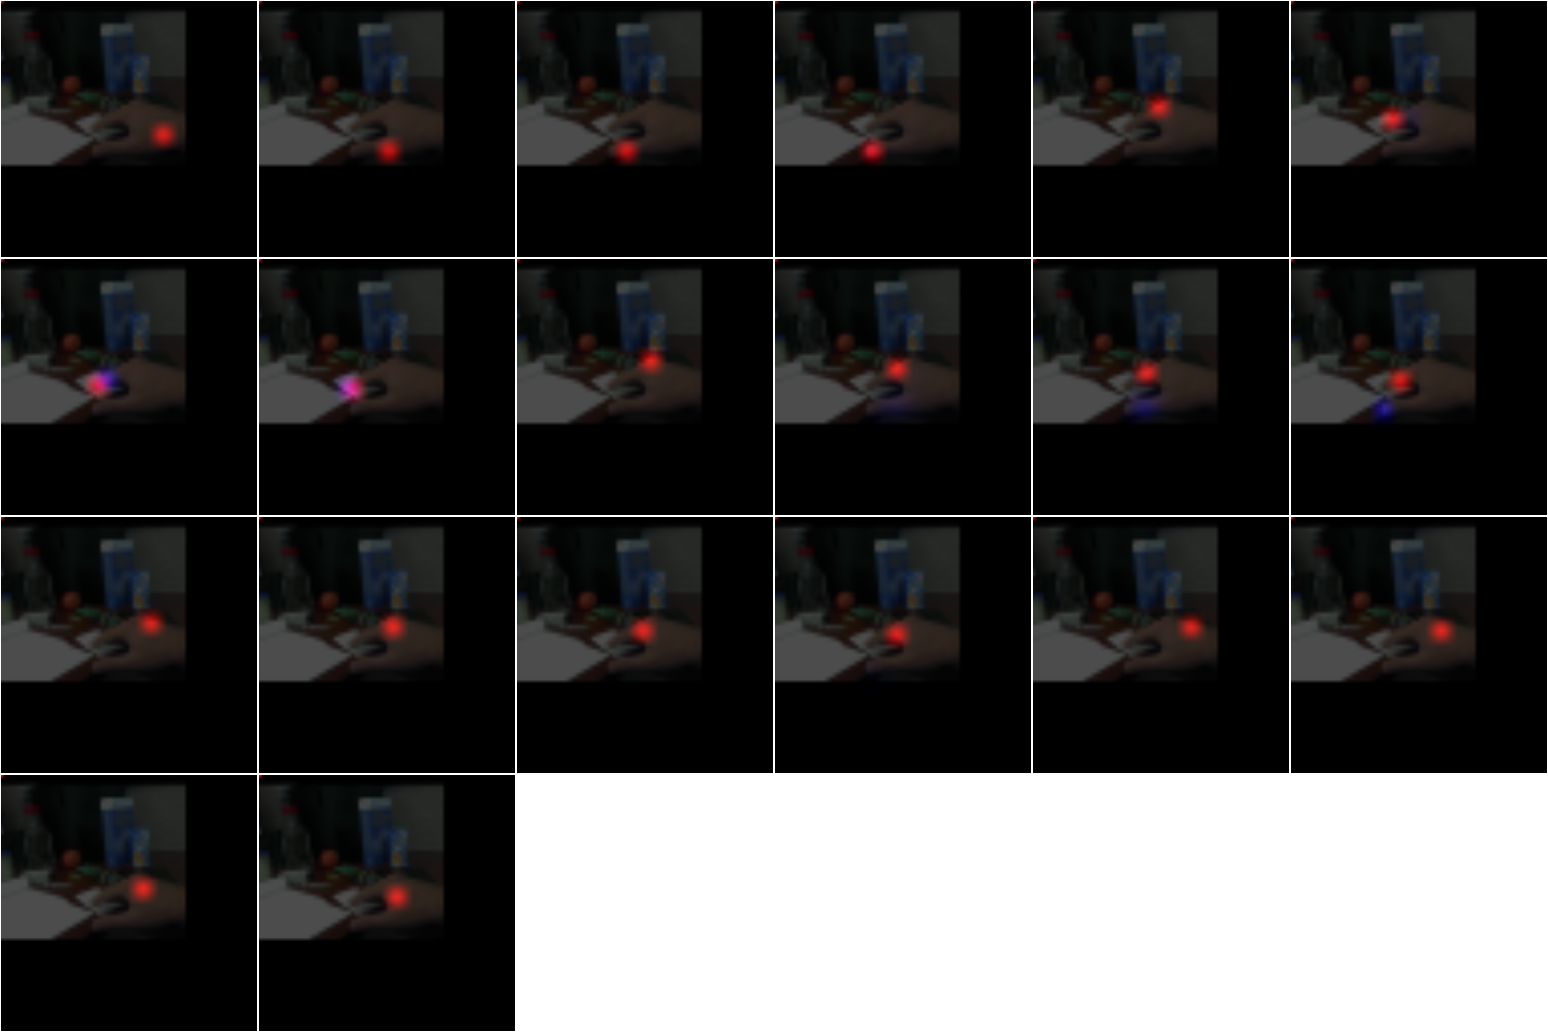

In [43]:
tmpIdx = 2
if hms then
    -- Prepare heatmap visualization
    local hmImg = heatmapVisualization('test',idxs[tmpIdx],hms[tmpIdx])
    print("Heatmaps: (red - ground truth, blue - predicted)"); sys.sleep(.01)
    itorch.image(hmImg)
end

# Get PCK for a given sample (over all joints)

In [47]:
imgIdx = idxs[tmpIdx]
pred = preds[tmpIdx]:narrow(2,3,2):clone()
pred = nn.utils.addSingletonDimension(pred)
inp, gt_hms = loadData('test',{imgIdx})
gt_hm = gt_hms[1][1]
gt = getPreds(nn.utils.addSingletonDimension(gt_hm))

In [123]:
-- dists = calcDists(pred, gt, torch.ones(preds:size(1))*opt.outputRes/10)
dists = calcDists(pred, gt, torch.ones(preds:size(1)))

In [124]:
displayPCK({dists}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}, {'sample'}, 'PCK', true)

PCK	


sample	0.10000000149012	



In [125]:
-- TODO replace this step by directly loading gt predictions in the heatmap space
-- For this we have to retrace the steps of the transform in the functions loadData, generateSample and transform 
inps, gts = loadData('test', idxs )

In [126]:
gt_joints = getPreds(gt_hms)

In [127]:
pred_joints = preds:narrow(3, 3, 2)

In [128]:
-- Normalized distances
-- all_dists = calcDists(pred_joints, gt_joints, torch.ones(pred_joints:size(1))*opt.outputRes/10)

-- Pixel distances
all_dists = calcDists(pred_joints, gt_joints, torch.ones(pred_joints:size(1)))

In [129]:
function pck(dists, jointIdx, threshold)
    return dists[jointIdx]:le(threshold):sum()*100/dists:size(2)
end

# Plot PCK for all joints with pixel thresholds

In [180]:
labels = {'thumb base', 'thumb1', 'thumb2', 'thumb tip',
'index base', 'index1', 'index2', 'index tip',
'middle base', 'middle', 'middle2', 'middle tip',
'ring base', 'ring1', 'ring2', 'ring tip',
'little base', 'little1', 'little2', 'little tip',
}

In [212]:
function plotJointEval(dists, evalFunc, labels, maxVal, curveSteps, maxPercentage)
    local curveSteps = curveSteps or 11
    local maxVal = maxVal or 1
    local maxPercentage = maxPercentage or 50

    local jointNb = dists:size(1)
    local thres = torch.linspace(0, maxVal, curveSteps)
    local scores = torch.zeros(jointNb, curveSteps)
    plotArgs = {}
    for jointIdx=1, jointNb do
        for thresIdx=1, curveSteps do
            t = thres[thresIdx]
            scores[jointIdx][thresIdx] = pck(dists, jointIdx, t)
        end
        plotArgs[jointIdx] = {labels[jointIdx], thres, scores[jointIdx], '-'}
    end

    require 'gnuplot'
    gnuplot.raw('set yrange [0:' .. maxPercentage .. ']')
    gnuplot.raw('set xrange [0:' .. maxVal .. ']')
    gnuplot.plot(unpack(plotArgs))
end

In [213]:
plotJointEval(all_dists, pck, labels, 10, 40, 60)

# Plot 

In [214]:
function meanerrors(dists, threshold)
    return dists:mean(1):le(threshold):sum()*100/dists:size(2)
end
function maxerrors(dists, threshold)
    return dists:max(1):le(threshold):sum()*100/dists:size(2)
end

In [247]:
function plotFrameEval(dists, evalFuncs, labels, maxVal, curveSteps, maxPercentage)
    local curveSteps = curveSteps or 11
    local maxVal = maxVal or 1
    local maxPercentage = maxPercentage or 50
    
    local thres = torch.linspace(0, maxVal, curveSteps)

    plotArgs = {}
    for i, func in ipairs(evalFuncs) do
        scores = torch.zeros(curveSteps)
        for thresIdx=1, curveSteps do
            t = thres[thresIdx]
            scores[thresIdx] = func(dists, t)
        end
        plotArgs[i] = {labels[i], thres, scores, '-'}
    end

    require 'gnuplot'
    gnuplot.raw('set yrange [0:' .. maxPercentage .. ']')
    gnuplot.raw('set xrange [0:' .. maxVal .. ']')
    gnuplot.plot(unpack(plotArgs)) 
end

In [248]:
plotFrameEval(all_dists, {meanerrors, maxerrors}, {"mean", "max"}, 10, 40, 50)